In [21]:
%load_ext autoreload
%autoreload 1

In [23]:
%aimport nrrd_file

In [35]:
from vesuvius import cubes

In [112]:
def parse_location_string(label):
    z, y, x = [int(substring) for substring in label.split('_')]
    return z, y, x


locations = []
for cube_location_string in list(cubes()[1][54][7.91].keys()):
    locations.append(parse_location_string(cube_location_string))

In [337]:
def save_cube(cube: Cube, mask=True):
    output_file_name = Path(cube.mask_url).name if mask else Path(cube.volume_url).name
    Nrrd.from_cube(cube, mask=mask).write(output_file_name)
    print(f"Wrote {output_file_name}")

In [336]:
for z, y, x in locations:
    cube = Cube(scroll_id=1, energy=54, resolution=7.91, z=z, y=y, x=x, cache=False)
    save_cube(cube, mask=False)

HTTPError: 404 Client Error: Not Found for url: https://dl.ash2txt.org/full-scrolls/Scroll1/PHercParis4.volpkg/seg-volumetric-labels/instance-annotated-cubes/00000_02408_04560/00000_02408_04560_volume.nrrd

In [261]:
import matplotlib.pyplot as plt
c1 = Nrrd.from_file("automatic-stitching-candidates/01744_02000_04304_mask.nrrd")
c2 = Nrrd.from_file("automatic-stitching-candidates/01744_02000_04560_mask.nrrd")

In [253]:
def find_papyrus_intersection(giver, receiver):
    intersection = np.logical_and(c1.volume[..., -1] !=0, c2.volume[..., 0] != 0)
    return intersection

intersection = find_papyrus_intersection(c1.volume, c2.volume)

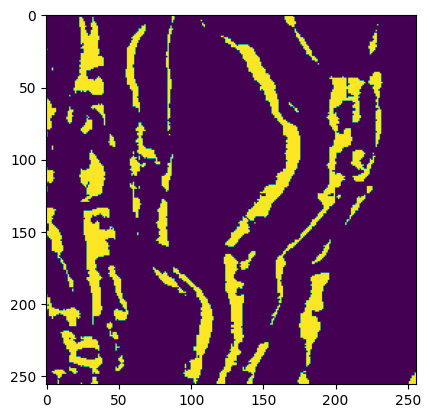

In [254]:
plt.imshow(intersection)

In [255]:
def create_label_mapping(intersection, giver, receiver):
    MIN_REQUIRED_OVERLAP = 10
    counts = {}
    for (a,b) in zip(receiver[..., 0][intersection], giver[..., -1][intersection]):
        if a in counts.keys():
            counts[a][b] += 1
        else:
            counts[a] = {i: 0 for i in range(32)}

    correspondences = {}
    for k, v in counts.items():
        highest = 0
        if max(v.values()) > MIN_REQUIRED_OVERLAP:
            for q, p in v.items():
                if p > v[highest]:
                    highest = q
        correspondences[k] = highest
    
    matched_keys = correspondences.keys()
    free_keys = [i for i in range(1,32) if i not in matched_keys]
    for i in range(1,32):
        if i not in matched_keys:
            correspondences[i] = free_keys.pop()
    return correspondences

In [257]:
correspondences = create_label_mapping(intersection, c1.volume, c2.volume)
print(correspondences)

{14: 3, 11: 2, 8: 1, 10: 11, 12: 4, 1: 21, 7: 16, 4: 10, 9: 5, 2: 31, 3: 30, 5: 29, 6: 28, 13: 27, 15: 26, 16: 25, 17: 24, 18: 23, 19: 22, 20: 21, 21: 20, 22: 19, 23: 18, 24: 17, 25: 16, 26: 15, 27: 13, 28: 6, 29: 5, 30: 3, 31: 2}


In [258]:
def match_labels(label_mapping: dict[int, int], volume):
    # Create lookup array with same dtype and known size
    lookup = np.zeros(33, dtype=np.uint8)  # 0-32 inclusive
    for k, v in label_mapping.items():
        lookup[k] = v
    
    # Map values using array indexing
    return lookup[volume]

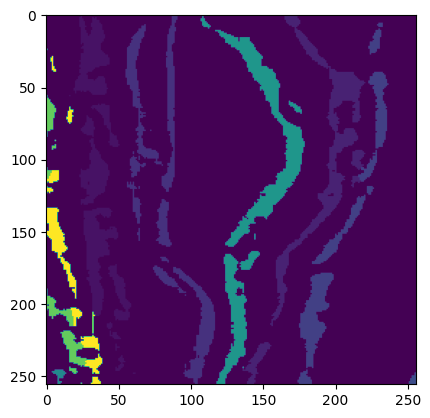

In [259]:
result = match_labels(correspondences, c2.volume)
plt.imshow(result[..., 0])

In [262]:
updated_c2 = Nrrd(result, c2.metadata)
updated_c2.write("automatic-stitching-candidates/01744_02000_04560_mask_updated.nrrd")

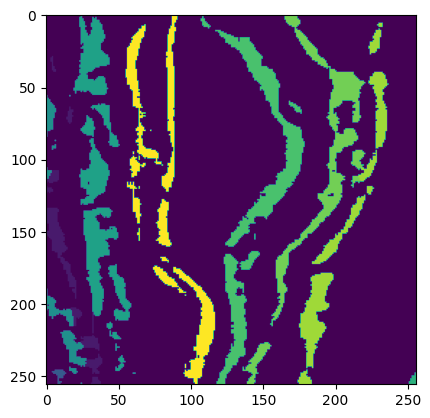

In [247]:
plt.imshow(c2.volume[..., 0])

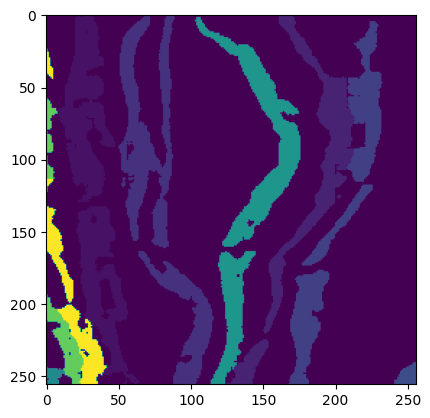

In [244]:
plt.imshow(c1.volume[..., -1])

In [275]:
# Try and figure out what's gone wrong with the ordering. candidate cubes:
from typing import Tuple
def cube_from_location(location_zyx: Tuple[int, int, int]):
    return Cube(scroll_id=1, energy=54, resolution=7.91, z=location_zyx[0], y=location_zyx[1], x=location_zyx[2], cache=False)


#locations[23], locations[24], locations[30]


In [276]:
cube1 = cube_from_location(locations[23])

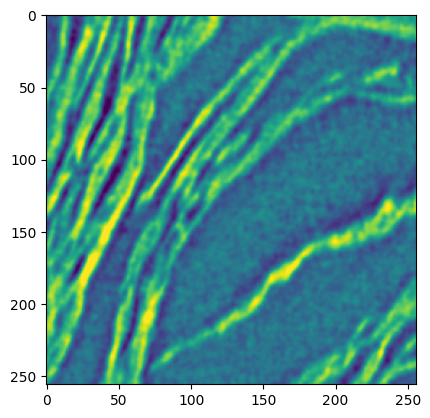

In [283]:
plt.imshow(cube1.volume[0])

In [320]:
cube1_nrrd = Nrrd.from_cube(cube1, mask=False)

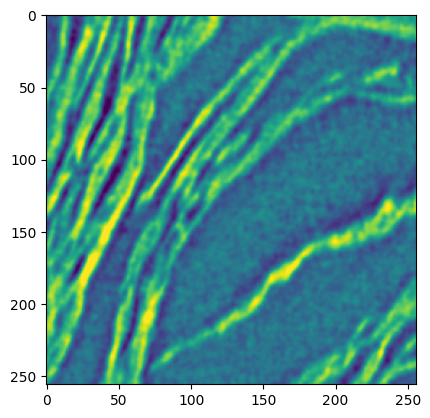

In [291]:
plt.imshow(cube1_nrrd.volume[0])

In [294]:
cube1_nrrd.volume[0] - cube1.volume[0] != 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [321]:
cube1_nrrd.write('__temp.nrrd')

In [322]:
cube1_reloaded = Nrrd.from_file('__temp.nrrd')

In [323]:
cube1_reloaded.metadata

OrderedDict([('type', 'uint8'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([256, 256, 256])),
             ('space directions',
              array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])),
             ('encoding', 'gzip'),
             ('space origin', array([2000., 2000., 2000.]))])

In [324]:
cube1_nrrd.metadata

{'type': 'uint8',
 'dimension': 3,
 'space': 'left-posterior-superior',
 'sizes': [256, 256, 256],
 'space directions': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'encoding': 'gzip',
 'space origin': array([2000., 2000., 2000.])}

In [305]:
cube1.x, cube1.y, cube1.z

(2000, 2000, 2000)

In [319]:
cube3 = cube_from_location(locations[30])

In [307]:
cube3.z, cube3.y, cube3.z

(2256, 2512, 4816)

In [325]:
m1 = Nrrd.from_file(Path()/'00000_02408_04560_volume.nrrd')

In [330]:
flattening_candidate = cube_from_location((0,2408, 4560))

In [331]:
save_cube(flattening_candidate, mask=False)
save_cube(flattening_candidate, mask=True)

Wrote 00000_02408_04560_volume.nrrd
Wrote 00000_02408_04560_mask.nrrd
